In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [46]:
X = torch.tensor([i for i in range(-50, 50)]).float()

In [47]:
def randvec(r1, r2, shape):
    return (r1 - r2) * torch.rand(shape) + r2

In [69]:
y = randvec(-500, 500, X.shape) + X + X.pow(2)

torch.Tensor

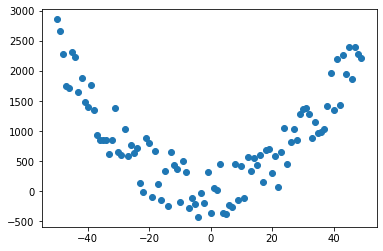

In [49]:
plt.scatter(X, y)

In [50]:
def mse(y_true, y_pred):
    e = y_true - y_pred
    return e.T.mm(e) / y_true.shape[0]

In [57]:
def create_features(X, degree=2):
    features = []
    for i in range(0, degree):
        if i != 0:
            X_d = X.pow(i + 1)
        else:
            X_d = X.clone()
        X_d -= X_d.mean()
        std = X_d.std()
        
        if std != 0:
            X_d /= std
            
        if len(X_d.shape) == 1:
            X_d = X_d.unsqueeze(1)
            
        if i == 0:
            ones_col = torch.ones((X_d.shape[0], 1), dtype=torch.float32)
            X_d = torch.cat([ones_col, X_d], axis=1)
        features.append(X_d)
    return features

In [58]:
features = create_features(X)

In [59]:
def get_weights_col(X):
    #return torch.normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1])).unsqueeze(1)
    return torch.ones(X.shape[1], 1)

def create_weights(features, degree):
    weights = []
    for i in range(degree):
        weights.append(get_weights_col(features[i]))
    return weights

In [60]:
weights = create_weights(features, 2)

In [61]:
def predict(features, weights):
    pred = 0
    for i in range(len(features)):
        pred += features[i].mm(weights[i])
    return pred

In [71]:
y_true = y.unsqueeze(1)

In [79]:
y_pred = predict(features, weights)
mse(y_true, y_pred)

tensor(1234949.6250)

tensor([[1234949.7500]])

In [74]:
def gradient(y_true, features, weights, lr=0.01, it=100):
    y_pred = predict(features, weights)
    (y_pred - y_true)

In [75]:
gradient(y_true, features, weights)

torch.Size([100, 1])
torch.Size([100, 1])


In [76]:
features[0].shape

torch.Size([100, 2])